# Segmentation of Indian Traffic

<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

# Task 1: Preprocessing

In [ ]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib

import os
import pdb
import json

import glob

## 1. Get all the file name and corresponding json files

In [ ]:
# # if using colab

from google.colab import drive

drive.mount('/gdrive')
!unzip "../gdrive/MyDrive/Copy of data.zip"



Streaming output truncated to the last 5000 lines.
  inflating: data/images/377/frame28480_leftImg8bit.jpg  
  inflating: data/images/377/frame28699_leftImg8bit.jpg  
  inflating: data/images/377/frame28808_leftImg8bit.jpg  
  inflating: data/images/377/frame29080_leftImg8bit.jpg  
  inflating: data/images/377/frame29271_leftImg8bit.jpg  
  inflating: data/images/377/frame29435_leftImg8bit.jpg  
  inflating: data/images/377/frame29653_leftImg8bit.jpg  
  inflating: data/images/377/frame29817_leftImg8bit.jpg  
  inflating: data/images/377/frame30062_leftImg8bit.jpg  
  inflating: data/images/377/frame30199_leftImg8bit.jpg  
  inflating: data/images/377/frame3039_leftImg8bit.jpg  
  inflating: data/images/377/frame30417_leftImg8bit.jpg  
  inflating: data/images/377/frame30499_leftImg8bit.jpg  
  inflating: data/images/377/frame30608_leftImg8bit.jpg  
  inflating: data/images/377/frame30744_leftImg8bit.jpg  
  inflating: data/images/377/frame30908_leftImg8bit.jpg  
  inflating: data/imag

In [ ]:
def return_file_names_df(root_dir):
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    images = []
    json = []
    for i in sorted(os.listdir(root_dir+'/images')):
      for j in sorted(os.listdir(root_dir+'/images/'+i)):
        images.append(root_dir+'/images/'+i+'/'+j)
        
    for i in sorted(os.listdir(root_dir+'/mask')):
      for j in sorted(os.listdir(root_dir+'/mask/'+i)):
        json.append(root_dir+'/mask/'+i+'/'+j)

    data_df = pd.DataFrame(columns=['image','json'])

    data_df['image'] = images
    data_df['json'] = json
    
    return data_df

In [ ]:
data_df = return_file_names_df('data')
data_df.head()

,image,json
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json


> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [ ]:

def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [ ]:
grader_1(data_df)

True

In [ ]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [ ]:
# # sample solution - to  read json file
# file = data_df["json"][1] # 'data\\mask\\201\\frame0029_gtFine_polygons.json'


# # Opening JSON file
# f = open(file)

# # returns JSON object as  a dictionary
# data = json.load(f)

# # Iterating through the json 
# labels = set([i["label"] for i in data['objects']])

# print(labels)
    
# # Closing file
# f.close()


In [ ]:
def return_unique_labels(data_df):
    
    list_label = []
    for file in  data_df["json"]:
        # read and store all the objects present in that file
        f = open(file)
        # returns JSON object as  a dictionary
        data = json.load(f)
        # Iterating through the json 
        labels = list(set([i["label"] for i in data['objects']]))
        # concatenating
        list_label = list_label + labels   
        f.close()   

    # compute the unique objects and retrun them
    unique_labels = set(list_label)
    # if open any json file using any editor you will get better sense of it
    return unique_labels

In [ ]:
unique_labels = return_unique_labels(data_df)

In [ ]:
len(unique_labels)

40

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [ ]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [ ]:
## sample solution - to open and read and extract information from json file
# file = data_df["json"][0]

# # read and store all the objects present in that file
# f = open(file)
# # returns JSON object as  a dictionary
# data = json.load(f)
# # Iterating through the json 

# polygons = [ [tuple(p_val)  for p_val in dicts["polygon"]  ] for dicts in data['objects']]
# labels = list( [ dicts['label']  for dicts in data['objects']] )
# # labels

In [ ]:
def get_poly(file):
    # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    # height of the image
    f = open(file)
    data = json.loads(f.read())
    w = data['imgWidth']
    h = data['imgHeight']
    label = []
    vertexlist = []

    for i in data['objects']:
      label.append(i['label'])
      vertex = []
      for j in i['polygon']:
        vertex.append(tuple(j))
      vertexlist.append(vertex)
    return w, h, label, vertexlist

In [ ]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

 **Example**

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

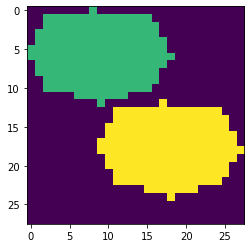

In [ ]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
import matplotlib.pyplot as plt 
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [ ]:
for i in sorted(os.listdir('data/images')):
   os.makedirs('data/output/'+i)

In [ ]:
def compute_masks(data_df):
    # after you have computed the vertexlist plot that polygone in image like this
    
    # img = Image.new("RGB", (w, h))
    # img1 = ImageDraw.Draw(img)
    # img1.polygon(vertexlist[i], fill = label_clr[label[i]])
    
    # after drawing all the polygons that we collected from json file, 
    # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
    
    # after saving the image into disk, store the path in a list
    # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
    mask = []

    for i in data_df['json']:
            w, h, label, vertexlist = get_poly(i)
            img = Image.new("RGB", (w, h))
            img1 = ImageDraw.Draw(img)
            for j in range(len(label)):
                if(len(vertexlist[j])>1):
                    img1.polygon(vertexlist[j], fill = label_clr[label[j]])
            img = np.array(img)
            im = Image.fromarray(img[:,:,0])
            im.save('data/output/'+i[10:39]+'.png')
            mask.append('data/output/'+i[10:39]+'.png')

    data_df['mask'] = mask
    return data_df

In [ ]:
%%time
data_df = compute_masks(data_df)
data_df.head()


CPU times: user 3min 56s, sys: 2.58 s, total: 3min 59s
Wall time: 4min 5s


,image,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4008 entries, 0 to 4007
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   4008 non-null   object
 1   json    4008 non-null   object
 2   mask    4008 non-null   object
dtypes: object(3)
memory usage: 94.1+ KB


In [ ]:
#saving the final dataframe to a csv file
data_df.to_csv('preprocessed_data.csv', index=False)

# Task 2: Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

## Task 2.1: Dice loss

<pre>
* Explain the Dice loss
* 1. Write the formualtion
* 2. Range of the loss function
* 3. Interpretation of loss function
* 4. Write your understanding of the loss function, how does it helps in segmentation
</pre>

> **Explain the Dice loss**

  - dice loss is basically used for image segmentation taks, it is originated from Sorensen-dice coefficient. Sorensen-dice coefficient term is wastly used in statistics to gauge the similarity between of two samples.
  - it tells, how much area of pridicted image is correctly matching with ground truth 


> **Dice loss formula:**

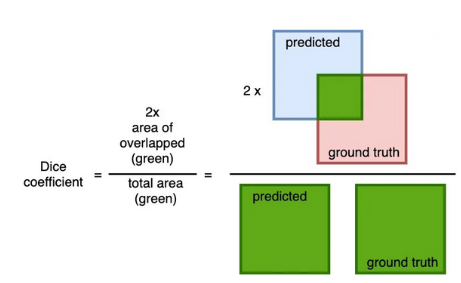

or 

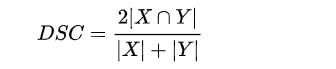

> **Range of the loss function**

  - range of DSC is between 0 to 1.
  - here 0 is worse condition and 1 is ideal.

> **Interpretation of loss function**
    
  - DSE tells how much area is overlapping
  - here numerator tell how much area are intersecting(/match / common) 
  - and denominator is sum of both image's area or total area
  - if area in predicted image is matches more with actual image than our DSE increases which mean our model is good and vice-versa
  - ideal value DSE is 1.

> **Write your understanding of the loss function, how does it helps in segmentation**

- ex- suppose we have binary image classfication where we have 0 and 1 values, in both actual and prodicted image 

- now  in order to compute DCE  where formula is

 =  2 x (A intersection B )/ total area
- we compute (A intersection B ) by elementwise multiplication, and 1 is represented (as green in numerator- in above image) as comman area and 
- total area is total number of pixel is both image 
- after doing division operation we will get the score(in range of 0-1) which tell the perfomance of  model (or segmentation)





## Task 2.2: Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* As shown in the reference notebook plot 20 images from the test data along with its segmentation map, predicted map.
</pre>

In [ ]:
# data_df = pd.read_csv("/content/preprocessed_data.csv")
data_df.sample()


,image,json,mask
700,data/images/237/frame8984_leftImg8bit.jpg,data/mask/237/frame8984_gtFine_polygons.json,data/output/237/frame8984_gtFine_polygons.png


In [ ]:

from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(data_df, test_size=0.20, random_state=42)
X_train = X_train.reset_index(drop=True)


In [ ]:
# unique classes
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}
classes = np.array(list(set(label_clr.values())))//10
classes = sorted(classes)

print(classes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


**dependency**

In [ ]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
import tensorflow as tf
import keras

!pip install -U segmentation-models==1.0.1
from keras.utils.layer_utils import get_source_inputs
import segmentation_models as sm
sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')
from segmentation_models import Unet
import imgaug.augmenters as iaa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.3 MB/s 
Segmentation Models: using `keras` framework.


### loading model

In [ ]:
# loading unet model with backbone - resnet34 
# https://segmentation-models.readthedocs.io/en/latest/tutorial.html#training-with-non-rgb-data

model = sm.Unet('resnet34', encoder_weights="imagenet", classes=21, activation='softmax',encoder_freeze=True, input_shape=(256, 256,3))


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 512, 512, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 256, 256, 64  9408        ['zero_padding2d[0][0]']   

### funtions for preprocess

In [ ]:
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
# aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()
    
# def normalize_image(mask):
#     mask = mask/255
#     return mask
from segmentation_models import get_preprocessing
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    CLASSES = ['unlabeled & out of roi', 'road', 'parking & drivable fallback', 'sidewalk', 'non-drivable fallback & rail track', 'person & animal', 'rider', 'motorcycle & bicycle',\
               'autorickshaw & car', 'truck & bus & vehicle fallback & trailer & caravan', 'curb & wall', 'fence & guard rail', 'billboard & traffic sign & traffic light',\
               'pole & polegroup & obs-str-bar-fallback', 'building & bridge & tunnel', 'vegetation', 'sky & fallback background', 'ego vehicle', 'ground', 'rectification border',\
               'train']
    def __init__(self,  img_path, mask_path, classes): # images_dir,
        
        # img_path - list of images path - ex data\images\338\frame55835_leftImg8bit.jpg
        self.images_fps   =  img_path #or [path for path in self.ids]
        self.masks_fps    = mask_path  #or  [path for path in mask_path]
        self.class_values =  classes #[self.CLASSES.index(cls.lower()) for cls in classes] 
        
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (256,256))
        image = preprocess_input(image)

        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, (256,256))
        #image_mask = normalize_image(mask)
        image_mask = mask/10 
        
        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        a = np.random.uniform()
        if a<0.25:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
        elif a<0.50:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
        elif a<0.75:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
        else:
            image = aug5.augment_image(image)
            image_mask = image_mask
        
            
        return image, image_mask
        
    def __len__(self):
        return len(self.images_fps)
    

In [ ]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)  

#### dataset preparation and callbacks

In [ ]:
classes= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


train_dataset = Dataset(X_train["image"],X_train["mask"], classes)
test_dataset  = Dataset(X_train["image"],X_train["mask"], classes)

BATCH_SIZE=8
train_dataloader = Dataloder(train_dataset, batch_size=8, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=8, shuffle=True)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, 21)


(8, 256, 256, 3)
(8, 256, 256, 21)


### compile and fit the model

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint

filepath='my_best_model_with_.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='iou_score', verbose=1, save_best_only=True, mode='max')
learning_rt = tf.keras.callbacks.ReduceLROnPlateau(monitor='iou_score', min_lr=0.0001,patience=2)
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)

In [ ]:
# https://github.com/qubvel/segmentation_models
# import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models.losses import DiceLoss

tf.keras.backend.clear_session()
# from segmentation_models import Unet

optim = tf.keras.optimizers.Adam(0.001)

focal_loss =DiceLoss() # DiceLoss() 

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 

model.compile(optim, focal_loss, metrics=[iou_score])

In [ ]:
# model.load_weights("/content/my_best_model_with_.hdf5")

In [ ]:
callback_list = [checkpoint]
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=10, callbacks=callback_list )

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.5443 - iou_score: 0.3661
Epoch 1: iou_score improved from 0.36232 to 0.36613, saving model to my_best_model_with_.hdf5
400/400 [==============================] - 197s 492ms/step - loss: 0.5443 - iou_score: 0.3661
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.5399 - iou_score: 0.3700
Epoch 2: iou_score improved from 0.36613 to 0.37000, saving model to my_best_model_with_.hdf5
400/400 [==============================] - 200s 499ms/step - loss: 0.5399 - iou_score: 0.3700
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.5221 - iou_score: 0.3865
Epoch 3: iou_score improved from 0.37000 to 0.38648, saving model to my_best_model_with_.hdf5
400/400 [==============================] - 202s 505ms/step - loss: 0.5221 - iou_score: 0.3865
Epoch 4/10
400/400 [==============================] - ETA: 0s - loss: 0.4857 - iou_score: 0.4271
Epoch 4: iou_score improved from 0.38648 to 0.42

In [ ]:
callback_list = [checkpoint]
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), validation_data=test_dataloader, epochs=10, callbacks=callback_list )

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.4263 - iou_score: 0.4852
Epoch 1: iou_score improved from 0.48399 to 0.48518, saving model to my_best_model_with_.hdf5
400/400 [==============================] - 404s 1s/step - loss: 0.4263 - iou_score: 0.4852 - val_loss: 0.4206 - val_iou_score: 0.4845
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.4244 - iou_score: 0.4906
Epoch 2: iou_score improved from 0.48518 to 0.49061, saving model to my_best_model_with_.hdf5
400/400 [==============================] - 401s 1s/step - loss: 0.4244 - iou_score: 0.4906 - val_loss: 0.4196 - val_iou_score: 0.5382
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.4240 - iou_score: 0.4926
Epoch 3: iou_score improved from 0.49061 to 0.49256, saving model to my_best_model_with_.hdf5
400/400 [==============================] - 399s 998ms/step - loss: 0.4240 - iou_score: 0.4926 - val_loss: 0.4179 - val_iou_score: 0.5011
Epoch 4/10
400/400 [==

In [ ]:
model.save_weights("final_unet_model.h5")

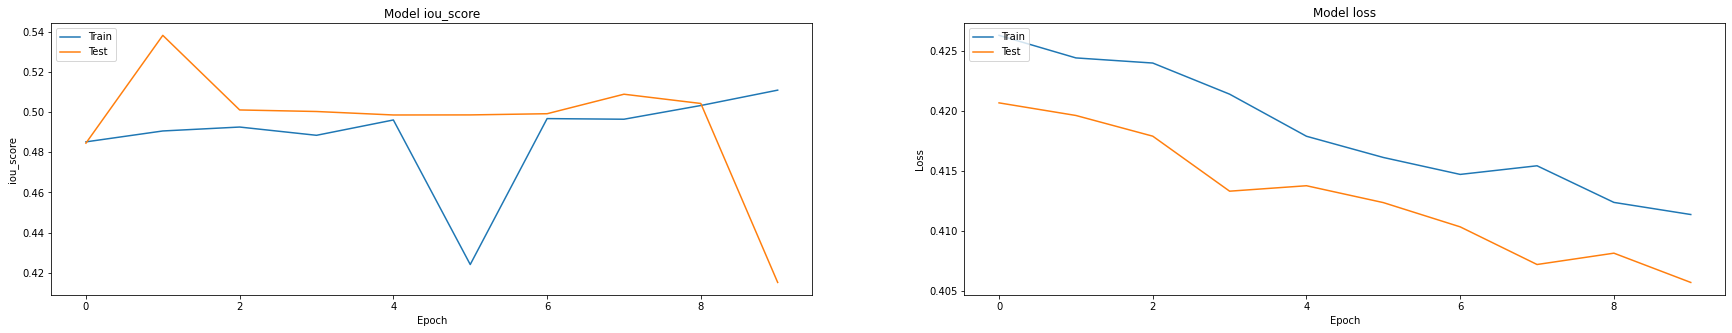

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Observation**

for the image segmentation task by using Unet we have got 

Train IOU score = .5033
and 
Test IOU score = .5043

*********************

### **visulizing model outputs on 10 test image**

In [ ]:
dir_path = '900_images'
for p, i in enumerate(X_test.iloc[:,0]):
    #original image
    image = cv2.imread(i , cv2.IMREAD_UNCHANGED) # os.path.join(dir_path, i+'.jpg'
    image = cv2.resize(image, (512,512)) 
    
    #predicted segmentation map
    predicted  = model.predict(image[np.newaxis,:,:,:])
    
    #original segmentation map
    image_mask = cv2.imread(os.path.join(dir_path, i+'.mask.jpg'), cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (512,512))
    

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask, cmap='gray', vmax=1, vmin=0)
    plt.subplot(133)
    plt.imshow(predicted[0,:,:,0], cmap='gray', vmax=1, vmin=0)
    plt.show()

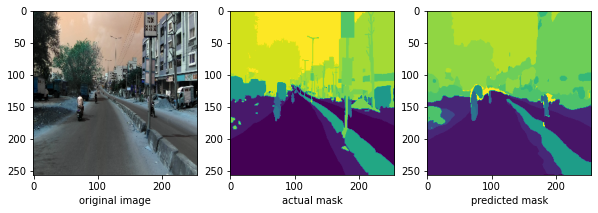

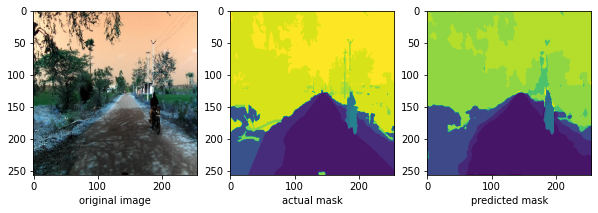

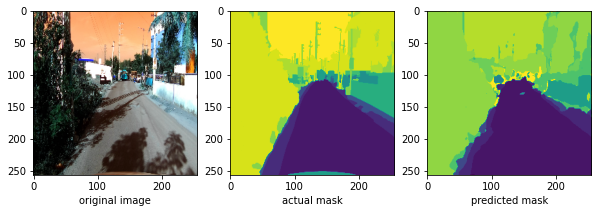

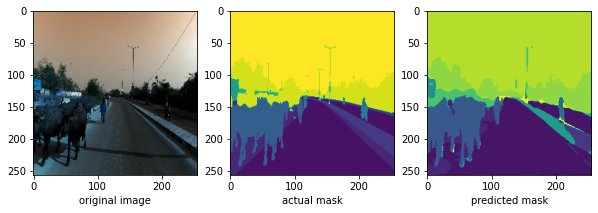

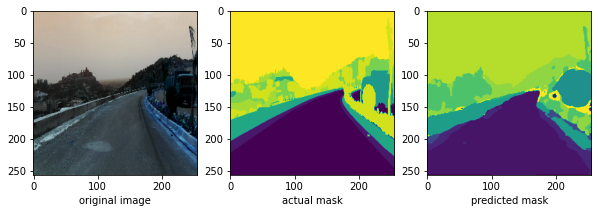

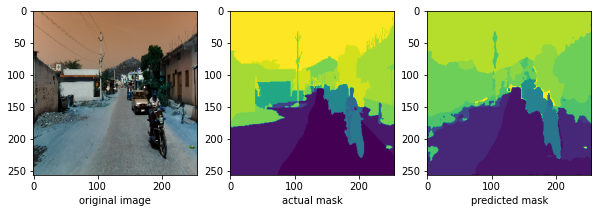

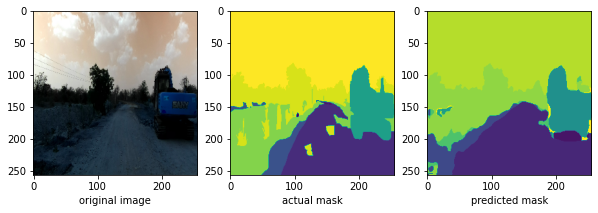

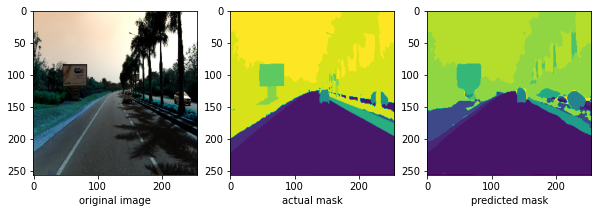

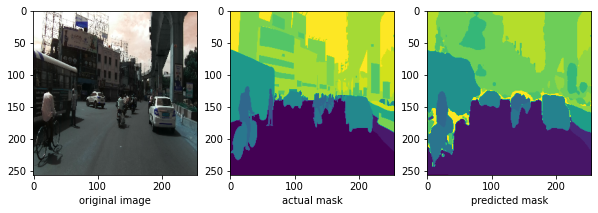

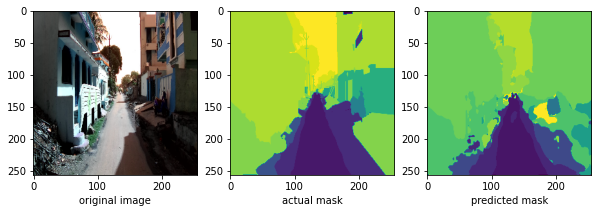

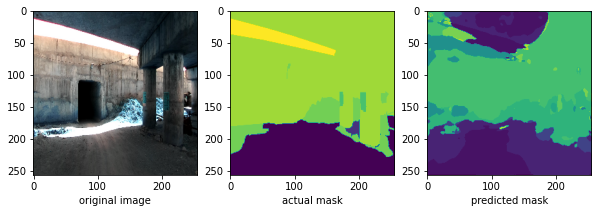

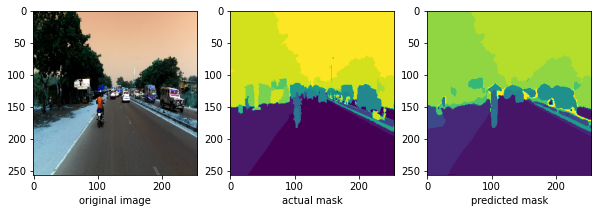

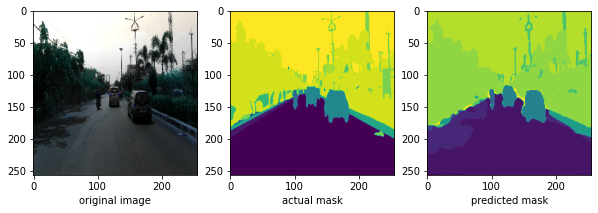

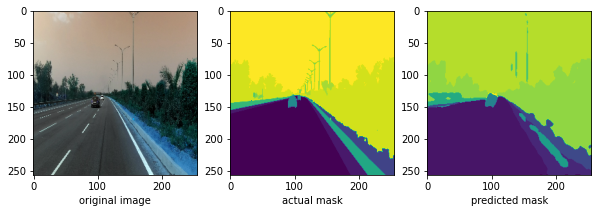

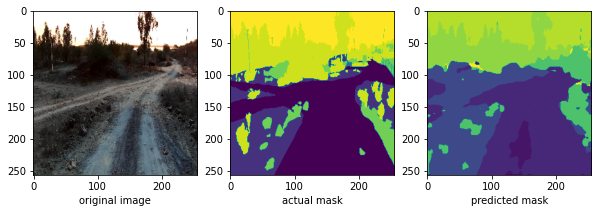

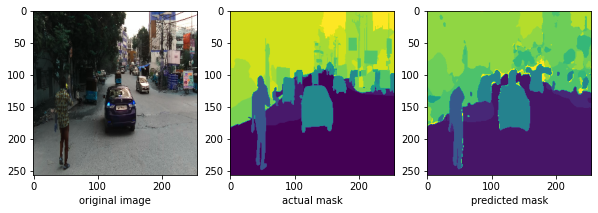

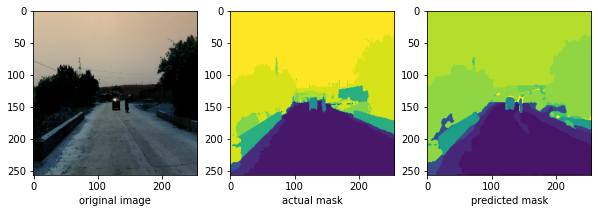

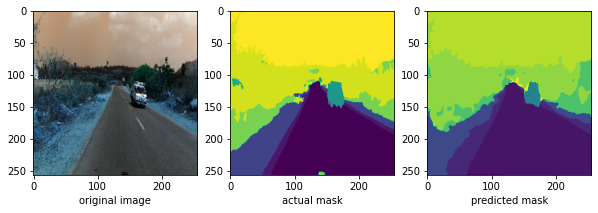

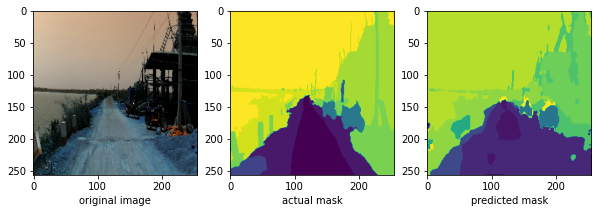

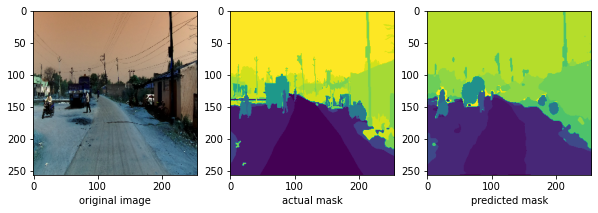

In [ ]:
# plotting the image

for i in range(20):
  # original image
  image = cv2.imread(X_test['image'].iloc[i], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (256,256))

  #predicted segmentation map
  # https://kiansoon.medium.com/semantic-segmentation-is-the-task-of-partitioning-an-image-into-multiple-segments-based-on-the-356a5582370e
  # We have to pick one class out of 21 class for which we get best probability and get the index of that class and prepare the matrix. after preparing the matrix from index
  # we will plot that matrix for predicted image
  predicted  = model.predict(image[np.newaxis,:,:,:])
  predicted = tf.argmax(predicted, axis=-1) 
  predicted = tf.expand_dims(predicted, axis=-1)

  #original segmentation map
  image_mask = cv2.imread(X_test['mask'].iloc[i], cv2.IMREAD_UNCHANGED)
  image_mask = cv2.resize(image_mask, (256,256))

  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.imshow(image)
  plt.xlabel("original image")
  plt.subplot(132)
  plt.imshow(image_mask)
  plt.xlabel("actual mask")
  plt.subplot(133)
  plt.imshow(predicted[0,:,:,0])
  plt.xlabel("predicted mask")
  plt.show()

# Task 3: Training CANet

In [ ]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:


!pip install -U segmentation-models==1.0.1
from keras.utils.layer_utils import get_source_inputs
import segmentation_models as sm
sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')
import imgaug.augmenters as iaa

* as a part of this assignment we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

#### convolutional_block and identity block

In [ ]:
# https://blog.paperspace.com/understanding-canet-architecture/
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], stride=1, name="conv_block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride

    def call(self, X):
        # write the architecutre that was mentioned above
        input = X

        # 1*1 Convolution block
        conv1 = Conv2D(self.F1, (1,1), strides=(self.stride,self.stride), padding='same')(X)
        bn1 = BatchNormalization(axis=3)(conv1)
        act1 = Activation('relu')(bn1)

        # 3*3 Convolution block
        conv2 = Conv2D(self.F2, (self.kernel,self.kernel), strides=(1,1), padding='same')(act1)
        bn2 = BatchNormalization(axis=3)(conv2)
        act2 = Activation('relu')(bn2)

        # 2nd 1*1 Convolution block
        conv3 = Conv2D(self.F3, (1,1), strides=(1,1), padding='same')(act2)
        bn3 = BatchNormalization(axis=3)(conv3)

        # skip connection convolution block
        skip_conv = Conv2D(self.F3, (self.kernel,self.kernel), strides=(self.stride,self.stride), padding='same')(input)
        skip_bn = BatchNormalization(axis=3)(skip_conv)
        skip_act = Activation('relu')(skip_bn)

        X = Add()([bn3, skip_act])
        X = Activation('relu')(X)
        
        return X

In [ ]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], name="identity_block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        
    def call(self, X):
        # write the architecutre that was mentioned above
        input = X

        # 1*1 Convolution block
        conv1 = Conv2D(self.F1, (1,1), strides=(1, 1), padding='same')(X)
        bn1 = BatchNormalization(axis=3)(conv1)
        act1 = Activation('relu')(bn1)

        # 3*3 Convolution block
        conv2 = Conv2D(self.F2, (self.kernel,self.kernel), strides=(1,1), padding='same')(act1)
        bn2 = BatchNormalization(axis=3)(conv2)
        act2 = Activation('relu')(bn2)

        # 2nd 1*1 Convolution block
        conv3 = Conv2D(self.F3, (1,1), strides=(1,1), padding='same')(act2)
        bn3 = BatchNormalization(axis=3)(conv3)

        X = Add()([bn3, input])
        X = Activation('relu')(X)

        return X

* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

#### global_flow() and context_flow()

In [ ]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim, channels, name="global_flow"):
        super().__init__(name=name)
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.channels = channels
   
    def call(self, X):
        # https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D
        # https://blog.paperspace.com/understanding-canet-architecture/
        # implement the global flow operatiom
        # Just for my reference - The 2D Global average pooling block takes a tensor of size (input width) x (input height) x (input channels) and computes the average value of all values across 
        # the entire (input width) x (input height) matrix for each of the (input channels).

        # Global average pooling layer
        # if input shape is 64 * 64 * 64 then operation of global average pooling will be (None, 64, 64 ,64) --> (None, 64)
        global_avg = GlobalAveragePooling2D()(X)

        # https://www.tensorflow.org/api_docs/python/tf/expand_dims?hl=en
        # expanding the dimentions
        # (None, 64) --> (None, 1, 64)
        global_avg = tf.expand_dims(global_avg, 1)
        # (None, 1, 64) --> (None, 1, 1, 64)
        global_avg = tf.expand_dims(global_avg, 1)

        # Batch Normalization layer
        bn = BatchNormalization(axis=3)(global_avg)
        # Activation layer
        act1 = Activation('relu')(bn)

        # 1*1 convolution layer
        conv = Conv2D(64,kernel_size=(1,1),strides=(1,1),padding='same')(act1)

        # Upsampling layer
        X = UpSampling2D(size = (self.input_dim, self.output_dim), interpolation='bilinear')(conv)

        return X

In [ ]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(name=name)
    def call(self, X):
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        # implement the context flow as mentioned in the above cell
        # https://blog.paperspace.com/understanding-canet-architecture/

        # Concatenate layer
        concate = Concatenate(axis = -1)([X[0], X[1]])

        #Avg Pooling layer
        avg_pool = AveragePooling2D(pool_size=(2,2))(concate)

        # 1st 3*3 conv layer
        conv1 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="same")(avg_pool)

        # 2nd 3*3 Conv layer
        conv2 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="same")(conv1)

        # 1st 1*1 conv layer
        conv3 = Conv2D(64, kernel_size=(1,1), strides=(1,1), padding="same")(conv2)

        # relu activation layer
        act = Activation('relu')(conv3)

        # 2nd 1*1 conv layer
        conv4 = Conv2D(64, kernel_size=(1,1), strides=(1,1), padding="same")(act)

        # sigmoid activation layer
        sigmoid = Activation('sigmoid')(conv4)

        # multiply 2nd 3*3 conv layer and sigmoid layer
        mult_layer = Multiply()([conv2, sigmoid])

        # adding mult layer and 2nd 3*3 conv layer
        add_layer = Add()([mult_layer, conv2])

        # upsampling layer
        X = UpSampling2D(size = (2, 2), interpolation='bilinear')(add_layer)

        return X

* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

#### fsm() and agcn()

In [ ]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)
        
    def call(self, X):
        # implement the FSM modules based on image in the above cells
        # https://blog.paperspace.com/understanding-canet-architecture/

        # 3*3 conv layer
        X = Conv2D(32, (3,3), (1,1), padding="same")(X)

        # global average pooling layer
        global_avg = GlobalAveragePooling2D()(X)

        # expanding the dimentions
        global_avg = tf.expand_dims(global_avg, 1)
        global_avg = tf.expand_dims(global_avg, 1)

        # 1*1 conv layer
        conv = Conv2D(32 ,kernel_size=(1,1),padding='same')(global_avg)

        #Batch normalisation layer
        bn = BatchNormalization()(conv)

        #sigmoid activation layer
        Y = Activation('sigmoid')(bn)

        # elementwise multiplication of X and Y
        multi_output = Multiply()([X,Y])

        # upsample layer
        FSM_Conv_T = UpSampling2D(size=(2,2),interpolation='bilinear')(multi_output)

        return FSM_Conv_T

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [ ]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(name=name)
        
    def call(self, X):
        # please implement the above mentioned architecture
        # 1st 7*1 convolution layer 
        conv1 = Conv2D(32, kernel_size=(7,1),padding='same')(X)

        # 1st 1*7 Conv layer
        conv2 = Conv2D(32, kernel_size=(1,7),padding='same')(X)

        # 2nd 7*1 conv layer
        conv3 = Conv2D(32, kernel_size=(7,1),padding='same')(conv2)

        # 2nd 1*7 conv layer
        conv4 = Conv2D(32, kernel_size=(1,7),padding='same')(conv1)

        # 1st concatenate layer
        add1 = Add()([conv3, conv4])

        # 3*3 conv layer
        conv5 = Conv2D(32, kernel_size=(3,3),padding='same')(add1)

        # 2nd concatenate layer
        X = Add()([conv5, add1])

        return X

*     <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

#### data pipeline

In [ ]:

from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(data_df, test_size=0.20, random_state=42)
X_train = X_train.reset_index(drop=True)


In [ ]:
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
# aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()
    
# def normalize_image(mask):
#     mask = mask/255
#     return mask
from segmentation_models import get_preprocessing
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    CLASSES = ['unlabeled & out of roi', 'road', 'parking & drivable fallback', 'sidewalk', 'non-drivable fallback & rail track', 'person & animal', 'rider', 'motorcycle & bicycle',\
               'autorickshaw & car', 'truck & bus & vehicle fallback & trailer & caravan', 'curb & wall', 'fence & guard rail', 'billboard & traffic sign & traffic light',\
               'pole & polegroup & obs-str-bar-fallback', 'building & bridge & tunnel', 'vegetation', 'sky & fallback background', 'ego vehicle', 'ground', 'rectification border',\
               'train']
    def __init__(self,  img_path, mask_path, classes): # images_dir,
        
        # img_path - list of images path - ex data\images\338\frame55835_leftImg8bit.jpg
        self.images_fps   =  img_path #or [path for path in self.ids]
        self.masks_fps    = mask_path  #or  [path for path in mask_path]
        self.class_values =  classes #[self.CLASSES.index(cls.lower()) for cls in classes] 
        
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (256,256))
        image = preprocess_input(image)

        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, (256,256))
        #image_mask = normalize_image(mask)
        image_mask = mask/10 
        
        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        a = np.random.uniform()
        if a<0.25:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
        elif a<0.50:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
        elif a<0.75:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
        else:
            image = aug5.augment_image(image)
            image_mask = image_mask
        
            
        return image, image_mask
        
    def __len__(self):
        return len(self.images_fps)

class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)  
    

In [ ]:
classes= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


train_dataset = Dataset(X_train["image"],X_train["mask"], classes)
test_dataset  = Dataset(X_train["image"],X_train["mask"], classes)

BATCH_SIZE=8
train_dataloader = Dataloder(train_dataset, batch_size=8, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=8, shuffle=True)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, 21)


(8, 256, 256, 3)
(8, 256, 256, 21)


#### model architecture

In [ ]:
X_input = Input(shape=(256,256,3))

# Stage 1
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)
print(X.shape)

# C1 channel
# convolution block
C1 = convolutional_block(kernel = 3, filters = [4,4,8], stride=2, name='conv2')(X)
print('C1 shape = ', C1.shape)
# Identity block 
I1 = identity_block(kernel = 3, filters = [4,4,8], name='iden1')(C1)
print('I1 shape = ', I1.shape)

# C2 channel
# convolution block
C2 =  convolutional_block(kernel = 3, filters = [8,8,16], stride=2, name='conv3')(I1)
print('C2 shape = ', C2.shape)
# 1st Identity block
I21 = identity_block(kernel = 3, filters = [8,8,16], name='iden2')(C2)
print('I21 shape = ', I21.shape)
# 2nd Identity block
I22 = identity_block(kernel = 3, filters = [8,8,16], name='iden3')(I21)
print('I22 shape = ', I22.shape)

# C3 channel
# convolution block
C3 = convolutional_block(kernel = 3, filters = [16,16,32], stride=1, name='conv4')(I22)
print('C3 shape = ', C3.shape)
# 1st Identity block
I31 = identity_block(kernel = 3, filters = [16,16,32], name='iden4')(C3)
print('I31 shape = ', I31.shape)
# 2nd Identity block
I32 = identity_block(kernel = 3, filters = [16,16,32], name='iden5')(I31)
print('I32 shape = ',I32.shape)
# 3rd Identity block
I33 =  identity_block(kernel = 3, filters = [16,16,32], name='iden6')(I32)
print('I33 shape = ', I33.shape)

# C4 channel
# convolution block
C4 = convolutional_block(kernel = 3, filters = [32,32,64], stride=1, name='conv5')(I33)
print('C4 shape = ', C4.shape)
# 1st Identity block
I41 = identity_block(kernel = 3, filters = [32,32,64], name='iden7')(C4)
print('I41 shape = ', I41.shape)
# 2nd Identity block
I42 = identity_block(kernel = 3, filters = [32,32,64], name='iden8')(I41)
print('I42 shape = ', I42.shape)
# 3rd Identity block
I43 = identity_block(kernel = 3, filters = [32,32,64], name='iden9')(I42)
print('I43 shape = ', I43.shape)
# 4th Identity block
I44 =  identity_block(kernel = 3, filters = [32,32,64], name='iden10')(I43)
print('I44 shape = ', I44.shape)

input_dim = I44.shape[1]
output_dim = I44.shape[2]
channels = I44.shape[-1]

# Global Flow
glob_flow = global_flow(input_dim, output_dim, channels)(I44)
print('Global flow = ', glob_flow.shape)

# 1st Context flow
cont_flow1 = context_flow(name = 'cont1')([I44, glob_flow])
print('1st Context flow = ', cont_flow1.shape)

# 2nd context flow
cont_flow2 = context_flow(name = 'cont2')([I44, cont_flow1])
print('2nd context flow = ', cont_flow2.shape)

# 3rd context flow
cont_flow3 = context_flow(name = 'cont3')([I44, cont_flow2])
print('3rd context flow = ', cont_flow3.shape)

# feature selection module
result = Add()([glob_flow, cont_flow1, cont_flow2, cont_flow3])
print('sum of above = ', result.shape)
fsm1 = fsm()(result)
print('FSM shape = ', fsm1.shape)

# AGCN module
agcn1 = agcn()(C1)
print('agcn shape = ', agcn1.shape)

# concatinng FSM and AGCN 
concat = Concatenate()([fsm1, agcn1])
print('concatenated shape = ', concat.shape)

# final convolution layer
final_conv = Conv2D(filters=21, kernel_size=(1,1), strides=(1,1), padding="same")(concat)
print('final convolution shape = ', final_conv.shape)

# upsampling layer
upsamp = UpSampling2D((4,4), interpolation="bilinear")(final_conv)
print('shape after upsampling = ', upsamp.shape)

# output layer
output = Activation('softmax')(upsamp)
print('Final shape = ', output.shape)

(None, 128, 128, 64)
C1 shape =  (None, 64, 64, 8)
I1 shape =  (None, 64, 64, 8)
C2 shape =  (None, 32, 32, 16)
I21 shape =  (None, 32, 32, 16)
I22 shape =  (None, 32, 32, 16)
C3 shape =  (None, 32, 32, 32)
I31 shape =  (None, 32, 32, 32)
I32 shape =  (None, 32, 32, 32)
I33 shape =  (None, 32, 32, 32)
C4 shape =  (None, 32, 32, 64)
I41 shape =  (None, 32, 32, 64)
I42 shape =  (None, 32, 32, 64)
I43 shape =  (None, 32, 32, 64)
I44 shape =  (None, 32, 32, 64)
Global flow =  (None, 32, 32, 64)
1st Context flow =  (None, 32, 32, 64)
2nd context flow =  (None, 32, 32, 64)
3rd context flow =  (None, 32, 32, 64)
sum of above =  (None, 32, 32, 64)
FSM shape =  (None, 64, 64, 32)
agcn shape =  (None, 64, 64, 32)
concatenated shape =  (None, 64, 64, 64)
final convolution shape =  (None, 64, 64, 21)
shape after upsampling =  (None, 256, 256, 21)
Final shape =  (None, 256, 256, 21)


* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

In [ ]:
# write the complete architecutre
tf.keras.backend.clear_session()

model_2 = Model(inputs = X_input, outputs = output)

model_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 256, 256, 64  256         ['conv1[0][0]']                  
                                )                                                             

#### compile and fit 

In [ ]:
# import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models.losses import DiceLoss

loss = DiceLoss()

optim = tf.keras.optimizers.Adam(0.001)

model_2.compile(optim, loss, metrics=[iou_score])

In [ ]:
# callback_list = [checkpoint, learning_rt, tensorboard_callback]

model_2.fit(train_dataloader, epochs=30) # validation_data=test_dataloader, callbacks=callback_list

### Usefull tips:
* use "interpolation=cv2.INTER_NEAREST" when you are resizing the image, so that it won't mess with the number of classes
* keep the images in the square shape like $256*256$ or $512*512$
* Carefull when you are converting the (W, H) output image into (W, H, Classes)
* Even for the canet, use the segmentation model's losses and the metrics
* The goal of this assignment is make you familier in with computer vision problems, image preprocessing, building complex architectures and implementing research papers, so that in future you will be very confident in industry
* you can use the tensorboard logss to see how is yours model's training happening
* use callbacks that you have implemented in previous assignments

### Things to keep in mind

* You need to train  above built model and plot the train and test losses.
* Make sure there is no overfitting, you are free play with the identity blocks in C1, C2, C3, C4
* before we apply the final sigmoid activation, you can add more conv layers or BN or dropouts etc
* you are free to use any other optimizer or learning rate or weights init or regularizations

In [ ]:
11